# <center> LINEAR CLASSIFICATION </center>

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from random import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

## Getting training data

Data source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

This data it's for predicting stroke events from several patients

In [159]:
# data = pd.read_excel('admision.xlsx')
data = pd.read_csv('Data/stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [160]:
#We need hot encode the text data
dummie_data=pd.get_dummies(data, prefix_sep="_", dummy_na=False, columns=['work_type','smoking_status','Residence_type','gender','ever_married'])
#We drop all the columns we don't need on the input data
data_f = data.drop(["id"], axis ="columns")
dummie_data.drop(['bmi','id','stroke'], axis=1, inplace=True)
dummie_data.head()



,age,hypertension,heart_disease,avg_glucose_level,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Urban,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes
0,67.0,0,1,228.69,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
1,61.0,0,0,202.21,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1
2,80.0,0,1,105.92,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1
3,49.0,0,0,171.23,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1
4,79.0,1,0,174.12,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1


## Extracting data


In [161]:
# Formating the data 

x_data = dummie_data.to_numpy()
print(x_data.shape)
y_data = np.array([data['stroke'].values.tolist()]).T
print(y_data.shape)

pos_idx = (y_data == 1)
neg_idx = (y_data == 0)

y_pos = np.array([y_data[pos_idx]]).T
y_neg = np.array([y_data[neg_idx]]).T

print(y_pos.shape)
print(y_neg.shape)

# Normalize data

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaler= x_scaler.fit(x_data)
x_nom = x_scaler.transform(x_data)
y_scaler= y_scaler.fit(y_data)
y_nom = y_scaler.transform(y_data)

(5110, 20)
(5110, 1)
(249, 1)
(4861, 1)


# Visualizie the data

Text(0.5, 1.0, 'Stroke')

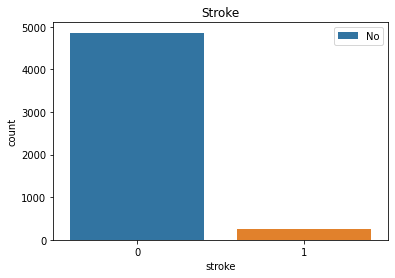

In [162]:
#plot the target variable
sns.countplot(x="stroke", data=data_f)
plt.legend(["No","Yes"])
plt.title("Stroke")

0    4861
1     249
Name: stroke, dtype: int64


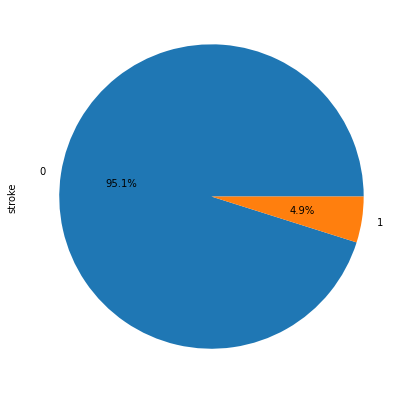

In [163]:
print(data["stroke"].value_counts())
data_f["stroke"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(7,7));

El problema de este ejercicio es que tenemos muchos que resultados negativos contra muchos resultados positivos, lo cual dificulta un poco la obtencion del algoritmo correcto y de una buena prediccion con estos datos.

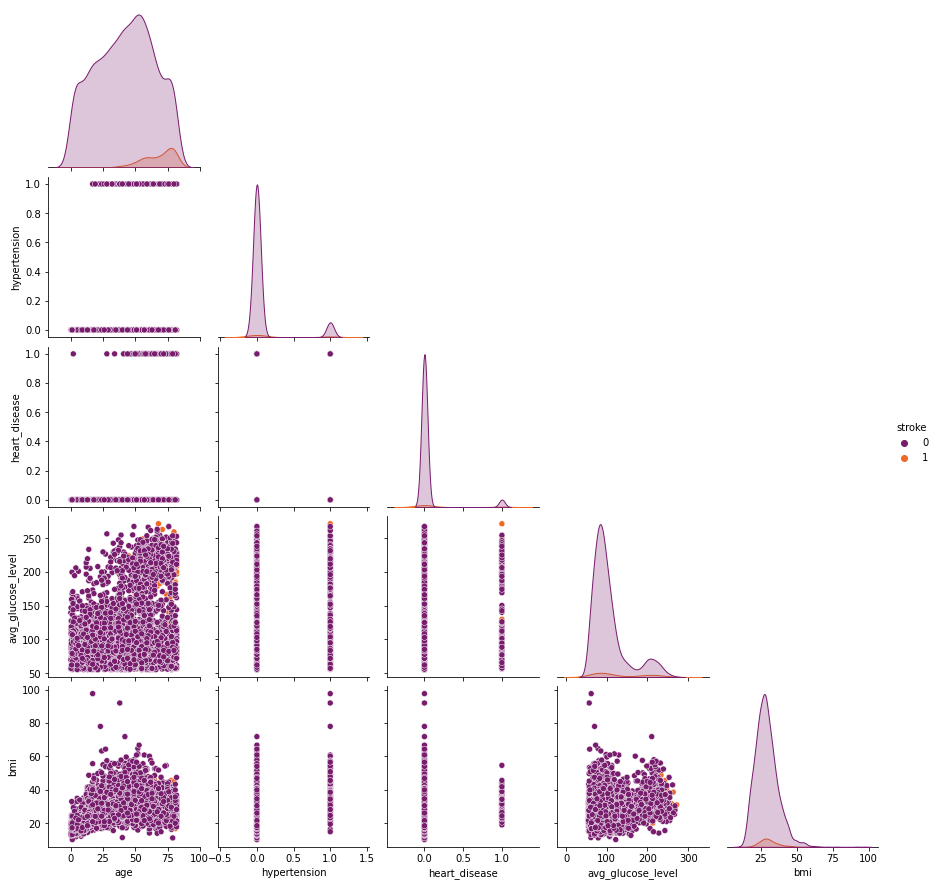

In [164]:
numerical= data_f.drop(['stroke'], axis=1).select_dtypes('number').columns
data_f[numerical].head().T
sns.pairplot(data_f, hue="stroke", palette="inferno", corner=True);

En estas graficas volvemos a darnos cuenta que nuestras muestras tienen muy pocos valores positivos a comparacion de los negativos, por lo cual hacer las predicciones se dificulta y somos porpensos a un subajuste.

# Logistic Regresion

In [122]:
# Spliting the data for the cross validation
kf = KFold(n_splits=10, shuffle=True)
# Making the logistic Regression model
classifier = LogisticRegression(random_state=101, class_weight='balanced')
# Training the model whith cross validation
results = cross_val_score(classifier, x_nom, np.ravel(y_nom,order='C'), cv=kf)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
# Making a prediction
x_train, x_test, y_train, y_test = train_test_split(x_nom, y_nom, random_state=101, test_size=0.3)
classifier.fit(x_train, np.ravel(y_train,order='C'))
predicted_y = classifier.predict(x_test)
# Making the confusion matrix
matrix = confusion_matrix(y_test, predicted_y)
# Transforming the confusion matrix to a dataframe for export
confmtrx = np.array(matrix)
confdt=pd.DataFrame(confmtrx, index=['No_stroke','Stroke'],
columns=['Predicted_No_Stroke', 'Predicted_Stroke', ])
print(confdt.head())
#Generating the report
report = classification_report(y_test, predicted_y)
print(report)


Accuracy: 73.933% (1.699%)
           Predicted_No_Stroke  Predicted_Stroke
No_stroke                 1074               372
Stroke                      19                68
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      1446
         1.0       0.15      0.78      0.26        87

    accuracy                           0.74      1533
   macro avg       0.57      0.76      0.55      1533
weighted avg       0.94      0.74      0.81      1533



# Neuronal Network

In [138]:
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu', input_shape=(20,)))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=16, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='rmsprop', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return network
# Wrap keras model for scikit-learn
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=10, 
                                 batch_size=100, 
                                 verbose=0)
# Making the 10 splits for the cross- validation
kf2 = KFold(n_splits=10, shuffle=True)
# Evaluate the neuronal network 
resultsn = cross_val_score(neural_network, x_nom, np.ravel(y_nom,order='C'), cv=kf2)
print("Accuracy: %.3f%% (%.3f%%)" % (resultsn.mean()*100.0, resultsn.std()*100.0))


/home/ulises/anaconda3/envs/ia37/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Accuracy: 95.127% (0.841%)


# Evaluation of the Neuronal Network

In [142]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_nom, y_nom, random_state=101, test_size=0.3)
# Working with the neuronal network like a sklearn model
neural_network.fit(x_train, y_train)
predicted_yn = neural_network.predict(x_test)
# Making the confusion matrix
matrixn = confusion_matrix(y_test, predicted_yn)
# Transforming the confusion matrix to a dataframe for export
confmtrxn = np.array(matrixn)
confdtn=pd.DataFrame(confmtrxn, index=['No_stroke','Stroke'],
columns=['Predicted_No_Stroke', 'Predicted_Stroke', ])
print(confdt.head())
#Generating the report
report = classification_report(y_test, predicted_yn)
print(report)


           Predicted_No_Stroke  Predicted_Stroke
No_stroke                 1074               372
Stroke                      19                68
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1446
         1.0       0.00      0.00      0.00        87

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.92      1533



/home/ulises/anaconda3/envs/ia37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ulises/anaconda3/envs/ia37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ulises/anaconda3/envs/ia37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
